# Buffer Analysis

## Introduction

This notebook demonstrates a buffer analysis to assess population exposure to air pollutants using PM2.5 data from the [U.S. EPA Air Quality System (AQS)](https://www.epa.gov/aqs). [Buffer analysis](https://en.wikipedia.org/wiki/Buffer_analysis) is essential in spatial data analysis for identifying areas impacted within a specified distance of a point location, such as air quality monitoring sites. Here, we will create buffers around PM2.5 monitoring sites and overlay population data to estimate the population potentially exposed to pollutants within these buffer zones.

### The United States Environmental Protection Agency's (EPA) Air Quality System (AQS) Database and API

The [EPA’s Air Quality System (AQS) API](https://aqs.epa.gov/aqsweb/documents/data_api.html) provides access to detailed, historical data on ambient air quality collected across the United States. Developed and maintained by the [United States Environmental Protection Agency (EPA)](https://www.epa.gov), the [Air Quality System (AQS)](https://www.epa.gov/aqs) houses data from thousands of air pollution monitoring stations operated by state, local, tribal, and federal agencies.

The AQS API offers row-level data on pollutant measurements, site metadata, and meteorological conditions, enabling research in environmental science, public health, and policy. AQS data include information about criteria pollutants like particulate matter (PM2.5 and PM10), ozone, sulfur dioxide, carbon monoxide, nitrogen dioxide, and lead. These data are highly valuable for understanding air quality trends and analyzing the relationship between pollution exposure and health outcomes across different demographics and geographies.

The [RAQSAPI package](https://cran.r-project.org/web/packages/RAQSAPI/index.html) is a tool for retrieving and managing AQS data in R, facilitating direct, programmatic access to EPA’s air quality database. By interfacing with the AQS API, RAQSAPI enables users to retrieve historical air quality data for specific pollutants, states, monitoring sites, or time periods directly into R for analysis.

#### Create Your EPA AQS API Key
To use the AQS API, users need to register for an API key.  To register via email, update the following link with your email address (replace "myemail@example.com" in the example with your email address) and navigate to the link.

https://aqs.epa.gov/data/api/signup?email=myemail@example.com

An email containing your API key will be sent to the registered address from aqsdatamart@epa.gov.

#### Overview
This notebook includes the following sections:

1. Setup
2. Data Acquisition
3. USA Data Extraction Specification and Submission

## 1 Setup

### 1a. Package Installation

Before running this script, you will need to install and load the following packages into your R environment:

[**dplyr**](https://cran.r-project.org/web/packages/dplyr/index.html) A package for data manipulation that provides a consistent set of functions to filter, arrange, summarize, and transform data. *dplyr* makes it easy to work with data frames and perform operations efficiently.  This notebook uses the the following functions from *dplyr*.

* [*group_by()*](https://dplyr.tidyverse.org/reference/group_by.html) for grouping by one or more variables
* [*summarize()*](https://dplyr.tidyverse.org/reference/summarise.html) for creating a new data frame using combinations of grouping variables
* This notebook also uses [*%>%*](https://magrittr.tidyverse.org/reference/pipe.html), referred to as the *pipe* operator, which is used to pass the output from one function directly into the next function for the purpose of creating streamlined workflows.  The *pipe* operator is a commonly used component of the [*tidyverse*](https://www.tidyverse.org).

[**ggplot2**](https://cran.r-project.org/web/packages/ggplot2/index.html) A package for creating graphics based on the "Grammar of Graphics".  This notebook uses the following functions from *ggplot2*.

* [*geom_sf()*](https://ggplot2.tidyverse.org/reference/ggsf.html) for visualizing (mapping) sf objects

[**ipumsr**](https://cran.r-project.org/web/packages/ipumsr/index.html) A package specifically designed to interact with IPUMS datasets, including NHGIS. It allows users to define and submit data extraction requests, download data, and read it directly into R for analysis.  This notebook uses the the following functions from *ipumsr*.

* *set_ipums_api_key()* for setting your IPUMS API key
* *define_extract_nhgis()* for defining an IPUMS NHGIS extract request
* *tst_spec()* for creating a tst_spec object containing a time-series table specification
* *submit_exract()* for submitting an extract request via the IPUMS API and return an *ipums_extract* object
* *wait_for_extract()* wait for an extract to finish processing
* *download_extract()* download an extract's data files
* *read_ipums_ddi()* for reading metadata about an IPUMS microdata extract from a DDI codebook (.xml) file
* *read_ipums_micro()* for reading data from an IPUMS microdata extract
* *read_nhgis()* for reading tabular data from an NHGIS extract
* *read_ipums_sf()* for reading spatial data from an IPUMS extract

[**RAQSAPI**](https://cran.r-project.org/web/packages/RAQSAPI/index.html) A package designed to interface with the [United States Environmental Protection Agency's (EPA) Air Quality System (AQS) Data Mart API](https://aqs.epa.gov/aqsweb/documents/data_api.html) and retrieve air monitoring data and associated metadata from the EPA's air quality monitoring service.  This notebook uses the the following functions from *RAQSAPI*.

* *aqs_credentials()* for setting the user credentials for the AQS API
* *aqs_annualsummary_by_state()* for returning annual data from the AQS API aggregated at the state level

[**sf**](https://cran.r-project.org/web/packages/sf/index.html) A package providing support for simple features (sf) geometry objects, a standardized way to encode spatial vector data.  This notebook uses the following functions from *sf*.

* [*st_as_sf()*](https://r-spatial.github.io/sf/reference/st_as_sf.html) for converting a foreign object on a sf object
* [*st_buffer()*](https://r-spatial.github.io/sf/reference/geos_unary.html) for carrying out a unary buffer operation on simple feature geometries
* [*st_intersection()*](https://r-spatial.github.io/sf/reference/geos_binary_ops.html) for performing geometric set operations with simple feature geometry collections
* [*st_transform()*](https://r-spatial.github.io/sf/reference/st_transform.html) for transforming or converting coordinates of simple feature

If you are working in the I-GUIDE environment, these packages should be already be installed.  However you will still need to load the packages into your workspace using *library* base R function.

In [1]:
library(dplyr)
library(ggplot2)
library(ipumsr)
# library(RAQSAPI)
library(sf)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Linking to GEOS 3.12.0, GDAL 3.7.2, PROJ 9.3.0; sf_use_s2() is TRUE



#### Connect your IPUMS API Key

Run the following code to enter your [IPUMS API key](https://account.ipums.org/api_keys).  Refer to the **Introduction to IPUMS and the IPUMS API** notebook for background on the IPUMS data repository and for instructions on setting up your IPUMS account and API key.

In [57]:
ipumps_api_key = readline("Please enter your IPUMS API key: ")
set_ipums_api_key(ipumps_api_key, save = T, overwrite = T)

Please enter your IPUMS API key:  59cba10d8a5da536fc06b59dd85f877c475a4c7d96dd08a9ce04d9d0


ERROR: Error in set_ipums_api_key(my_ipumps_api_key, save = T, overwrite = T): could not find function "set_ipums_api_key"


#### Connect your EPA AQS API Key

Run the following code to enter your [EPA AQS](https://aqs.epa.gov/aqsweb/documents/data_api.html) API username (email) and key.  Refer to the **Introduction to the Environmental Protection Agency (EPA) Air Quality System (AQS) Data Repository and API** notebook for background on the EPA AQS data repository and for instructions on setting up your EPA AQS API key.

In [12]:
aqs_api_email = readline("Please enter your EPA AQS API username (email): ")
aqs_api_key = readline("Please enter your EPA AQS API key: ")
# this step commented until the RAQSAPI package is installed
#aqs_credentials(api_email, aqs_api_key)

Please enter your EPA AQS API username (email):  vavramusser@gmail.com
Please enter your EPA AQS API key:  ochreosprey45


## 2. PM 2.5 Emissions Data Acquisition Using RAQSAPI

For this exercise, we will explore differences between populations living in high vs. low PM2 2.5 emissions areas.  To do this we will first we will acquire [PM2.5 (particulate matter)](https://en.wikipedia.org/wiki/Particulates) emission estimates at monitoring site locations for the state of California in 2023 - sourced from the from the U.S. EPA Air Quality System (AQS) via the AQS API

We will be using the *aqs_annualsummary_by_state()* function from the *RAQSAPI* package for our API request.  This function is specifically designed for retrieving annual data at the state level.  However, the *RAQSAPI* R pakcage provides many other functions for setting up API pulls with different parameterization.  Refer to the [*RAQSAPI* user manuel](https://cran.r-project.org/web/packages/RAQSAPI/RAQSAPI.pdf) for a comprehensive list of all available functions. 

To define the API request using the *aqs_annualsummary_by_state()* function, we need to provide the following information:

* [EPA AQS parameter code](https://www.epa.gov/aqs/aqs-code-list): we will use code "88101" corresponding to PM 2.5
* [state FIPS code](https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt)
* start date
* end date

For this example, we will use parameter code 88101 (correspoding to PM 2.5), California state FIPS code "06", and a start and end date of January 1 and December 31, 2023.

In [1]:
pm25_data <- aqs_annualsummary_by_state(
  parameter = "88101",                                # paraemter code for PM 2.5
  stateFIPS = 06,                                     # state FIPS code for California
  bdate = as.Date("20230101", format = "%Y%m%d"),     # start date (January 1, 2023)
  edate = as.Date("20231231", format = "%Y%m%d")      # end date (December 31, 2023)
)

ERROR: Error in aqs_annualsummary_by_state(parameter = "88101", stateFIPS = 6, : could not find function "aqs_annualsummary_by_state"


In [3]:
# temporary helper step until the RAQSAPI package is installed
pm25_data <- read.csv("pm25_data.csv")

The API request should return a tibble containing information on PM 2.5 emissions from monitoring sites in California.  Let's take a look at the first few rows of data.

In [4]:
head(pm25_data)

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,⋯,fiftieth_percentile,tenth_percentile,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
1,6,73,1006,88101,3,32.84232,-116.7683,NAD83,PM2.5 - Local Conditions,1,⋯,NA,NA,Alpine,"2300 VICTORIA DR., ALPINE",California,San Diego,Alpine,41740,"San Diego-Carlsbad, CA",2024-08-05
2,6,73,1006,88101,3,32.84232,-116.7683,NAD83,PM2.5 - Local Conditions,1,⋯,6.1,2.1,Alpine,"2300 VICTORIA DR., ALPINE",California,San Diego,Alpine,41740,"San Diego-Carlsbad, CA",2024-08-05
3,6,73,1006,88101,3,32.84232,-116.7683,NAD83,PM2.5 - Local Conditions,1,⋯,6.1,2.1,Alpine,"2300 VICTORIA DR., ALPINE",California,San Diego,Alpine,41740,"San Diego-Carlsbad, CA",2024-08-05
4,6,73,1006,88101,3,32.84232,-116.7683,NAD83,PM2.5 - Local Conditions,X,⋯,NA,NA,Alpine,"2300 VICTORIA DR., ALPINE",California,San Diego,Alpine,41740,"San Diego-Carlsbad, CA",2024-08-05
5,6,73,1006,88101,3,32.84232,-116.7683,NAD83,PM2.5 - Local Conditions,X,⋯,NA,NA,Alpine,"2300 VICTORIA DR., ALPINE",California,San Diego,Alpine,41740,"San Diego-Carlsbad, CA",2024-08-05
6,6,73,1006,88101,3,32.84232,-116.7683,NAD83,PM2.5 - Local Conditions,X,⋯,NA,NA,Alpine,"2300 VICTORIA DR., ALPINE",California,San Diego,Alpine,41740,"San Diego-Carlsbad, CA",2024-08-05


From this data preview, we can see that the first monitor in the dataset (site number 1006) is represented at least six times in the data.  The EPA AQS data returns information collected from monitoring sites but also provides monitoring results based on multiple different scenarios.

Let's compare the number of observations (rows) to the number of unique monitoring sites in our data.

In [13]:
# total number of observations
dim(pm25_data)[1]

# number of unique site numbers
length(unique(pm25_data$site_number))

[1] 1733

[1] 70

Our data has 1733 rows for 70 unique monitors!

Let's take a look at all the rows in our data set which correspond to site number 1006.  For this view we sill select a subset of the columns to focus on.

In [5]:
filter(pm25_data, site_number == 1006) %>%
select(site_number, sample_duration, pollutant_standard, metric_used, method, event_type, observation_count, validity_indicator, valid_day_count, arithmetic_mean, standard_deviation)

site_number,sample_duration,pollutant_standard,metric_used,method,event_type,observation_count,validity_indicator,valid_day_count,arithmetic_mean,standard_deviation
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>
1006,1 HOUR,NA,Observed Values,Multiple Methods Used,Events Excluded,3976,Y,353,6.485136,3.669158
1006,1 HOUR,NA,Observed Values,Multiple Methods Used,Events Included,8425,Y,353,6.569875,3.815335
1006,1 HOUR,NA,Observed Values,Multiple Methods Used,Concurred Events Excluded,8425,Y,353,6.569875,3.815335
1006,24-HR BLK AVG,PM25 24-hour 2006,Daily Mean,Multiple Methods Used,Events Excluded,166,N,352,6.416867,2.963999
1006,24-HR BLK AVG,PM25 Annual 2006,Quarterly Means of Daily Means,Multiple Methods Used,Events Excluded,166,N,352,6.416867,2.963999
1006,24-HR BLK AVG,PM25 24-hour 2012,Daily Mean,Multiple Methods Used,Events Excluded,166,N,352,6.416867,2.963999
1006,24-HR BLK AVG,PM25 Annual 2012,Quarterly Means of Daily Means,Multiple Methods Used,Events Excluded,166,N,352,6.416867,2.963999
1006,24-HR BLK AVG,PM25 24-hour 1997,Daily Mean,Multiple Methods Used,Events Excluded,166,N,352,6.416867,2.963999
1006,24-HR BLK AVG,PM25 Annual 1997,Quarterly Means of Daily Means,Multiple Methods Used,Events Excluded,166,N,352,6.416867,2.963999


Our dataset includes 20 rows for monitoring site number 1006 alone!  We can see, based on this view, that there are multiple conditions which differentiate the different rows of data, even those all of these rows correspond to PM 2.5 data from monitoring site 1006 from the year 2023.  Each of these rows corresponds to a different arithmetic mean summary statistic for the year.  But which aritmetic mean should we use for this site?

Our next goal is to limit this dataset down to a single row (and single corresponding arithmetic mean) for each of the monitoring sites in the data.  We will focus on a few important differences colums including:

1. validity indicator
2. pollutant standard
5. event type

First, let's filter our data to only rows which are flagged as valid (valitidy indicaor "Y") and which follow a specific pollutant standard.  To decide which pollutant standard we will choose, let's take a look at the differnt pollutant standards which are represented in our dataset.

In [7]:
unique(pm25_data$pollutant_standard)

[1] NA                  "PM25 24-hour 2006" "PM25 Annual 2006" 
[4] "PM25 24-hour 2012" "PM25 Annual 2012"  "PM25 24-hour 1997"
[7] "PM25 Annual 1997"  "PM25 24-hour 2024" "PM25 Annual 2024"

Our data includes 24-hour and annual standards based on the years 1997, 2006, 2012, and 2024.  Let's choose to focus on using data based on the 2024 annual standard and filter our data to only those rows which are valid (validity_indicator == "Y") and are based on the 2024 annual PM 2.5 pollutant standard (pollutant_standard == "PM25 Annual 2024").  For now, let's continue to only look at monitor 1006 (site_number == 1006) as an example site during our filtering process.

In [8]:
filter(pm25_data, site_number == 1006, validity_indicator == "Y", pollutant_standard == "PM25 Annual 2024") %>%
select(site_number, sample_duration, pollutant_standard, metric_used, method, event_type, observation_count, validity_indicator, valid_day_count, arithmetic_mean, standard_deviation)

site_number,sample_duration,pollutant_standard,metric_used,method,event_type,observation_count,validity_indicator,valid_day_count,arithmetic_mean,standard_deviation
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>
1006,24-HR BLK AVG,PM25 Annual 2024,Quarterly Means of Daily Means,Multiple Methods Used,Events Included,352,Y,352,6.507102,3.087302
1006,24-HR BLK AVG,PM25 Annual 2024,Quarterly Means of Daily Means,NA,No Events,355,Y,355,7.127324,5.497309


We are down to only two rows for site 1006!  Next, let's filter based on types of events which are included when calculating summary statistics for emissions.  Let's take a look at the different types of event inclusion scenarios which are represented in our dataset.

In [9]:
unique(pm25_data$event_type)

[1] "Events Excluded"           "Events Included"          
[3] "Concurred Events Excluded" "No Events"

Let's choose to filter our data to only rows where no events occurred (event_type == "No Events").

In [45]:
filter(pm25_data, site_number == 1006, validity_indicator == "Y", pollutant_standard == "PM25 Annual 2024", event_type == "No Events") %>%
select(site_number, sample_duration, pollutant_standard, metric_used, method, event_type, observation_count, validity_indicator, valid_day_count, arithmetic_mean, standard_deviation)

site_number,sample_duration,pollutant_standard,metric_used,method,event_type,observation_count,validity_indicator,valid_day_count,arithmetic_mean,standard_deviation
<int>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<int>,<dbl>,<dbl>
1006,24-HR BLK AVG,PM25 Annual 2024,Quarterly Means of Daily Means,NA,No Events,355,Y,355,7.127324,5.497309


We are now down to a single row of information for monitor 1006!  Let's create a new version of the data *pm25_filtered* which applies these filters (validity_indicator == "Y", pollutant_standard == "PM25 Annual 2024", and event_type == "No Events") to the entire dataset.

In [14]:
pm25_filtered <- filter(pm25_data,
                        validity_indicator == "Y",
                        pollutant_standard == "PM25 Annual 2024",
                        event_type == "No Events")

head(pm25_filtered)

,state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,⋯,fiftieth_percentile,tenth_percentile,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
,<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
1,6,59,7,88101,3,33.83062,-117.9385,WGS84,PM2.5 - Local Conditions,X,⋯,9.1,2.8,Anaheim,1630 W. PAMPAS LANE,California,Orange,Anaheim,31080,"Los Angeles-Long Beach-Anaheim, CA",2024-08-07
2,6,67,6,88101,3,38.61378,-121.3680,WGS84,PM2.5 - Local Conditions,X,⋯,6.5,2.6,Sacramento-Del Paso Manor,"DEL PASO-2701 AVALON DR, SACRAMENTO",California,Sacramento,Arden-Arcade,40900,"Sacramento--Roseville--Arden-Arcade, CA",2024-08-06
3,6,67,6,88101,1,38.61378,-121.3680,WGS84,PM2.5 - Local Conditions,7,⋯,6.1,2.8,Sacramento-Del Paso Manor,"DEL PASO-2701 AVALON DR, SACRAMENTO",California,Sacramento,Arden-Arcade,40900,"Sacramento--Roseville--Arden-Arcade, CA",2024-08-06
4,6,67,6,88101,2,38.61378,-121.3680,WGS84,PM2.5 - Local Conditions,7,⋯,7.1,2.8,Sacramento-Del Paso Manor,"DEL PASO-2701 AVALON DR, SACRAMENTO",California,Sacramento,Arden-Arcade,40900,"Sacramento--Roseville--Arden-Arcade, CA",2024-08-06
5,6,79,2007,88101,1,35.04673,-120.5878,NAD83,PM2.5 - Local Conditions,X,⋯,6.0,2.0,CDF,"2391 Willow Road, Arroyo Grande, California",California,San Luis Obispo,Arroyo Grande,42020,"San Luis Obispo-Paso Robles-Arroyo Grande, CA",2024-05-17
6,6,79,8002,88101,3,35.49453,-120.6662,WGS84,PM2.5 - Local Conditions,X,⋯,3.0,0.2,Atascadero,"5599 Traffic Way, Atascadero CA",California,San Luis Obispo,Atascadero,42020,"San Luis Obispo-Paso Robles-Arroyo Grande, CA",2024-05-17


We are still seeing some sites (e.g. site 6 in this preview) which correspond to more than one row.  Instead of creating another filtering criteria, let's simply select the row for each monitoring site which corresponds to the highest number of observations - assuming that a summary based on more observations will be more likely to be accurate.

In [15]:
pm25_filtered <- pm25_filtered %>%
  group_by(site_number) %>%
  slice_max(observation_count, with_ties = FALSE) %>%     # keeps only the row with the max observation_count for each group
  ungroup()

# View the result
head(pm25_filtered)

state_code,county_code,site_number,parameter_code,poc,latitude,longitude,datum,parameter,sample_duration_code,⋯,fiftieth_percentile,tenth_percentile,local_site_name,site_address,state,county,city,cbsa_code,cbsa,date_of_last_change
<int>,<int>,<int>,<int>,<int>,<dbl>,<dbl>,<chr>,<chr>,<chr>,⋯,<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<int>,<chr>,<chr>
6,9,1,88101,3,38.20185,-120.6803,NAD83,PM2.5 - Local Conditions,X,⋯,4.9,1.8,San Andreas-Gold Strike Road,"501 GOLD STRIKE ROAD, SAN ANDREAS",California,Calaveras,San Andreas,NA,NA,2024-08-06
6,53,2,88101,3,36.48187,-121.7333,NAD83,PM2.5 - Local Conditions,X,⋯,3.6,1.7,Carmel Valley,35 Ford Road,California,Monterey,Carmel Valley Village,41500,"Salinas, CA",2024-05-17
6,61,3,88101,1,38.93568,-121.0996,NAD83,PM2.5 - Local Conditions,X,⋯,5.2,0.7,Auburn-Atwood,"11645 Atwood Street, Auburn",California,Placer,Auburn,40900,"Sacramento--Roseville--Arden-Arcade, CA",2024-05-17
6,97,4,88101,3,38.40376,-122.8183,WGS84,PM2.5 - Local Conditions,X,⋯,3.8,1.3,Sebastopol,"103 Morris Street,",California,Sonoma,Sebastopol,42220,"Santa Rosa, CA",2024-05-17
6,57,5,88101,3,39.23348,-121.0556,NAD83,PM2.5 - Local Conditions,X,⋯,4.4,1.5,Grass Valley-Litton Building,"200 LITTON DR., GRASS VALLEY, CA",California,Nevada,Grass Valley,46020,"Truckee-Grass Valley, CA",2024-05-17
6,99,6,88101,3,37.48832,-120.8360,NAD83,PM2.5 - Local Conditions,X,⋯,8.4,3.2,Turlock,"900 S MINARET STREET, TURLOCK, CA",California,Stanislaus,Turlock,33700,"Modesto, CA",2024-08-06


We should now only have one row for each monitoring site.  But let's double check by quickly comparing the total number rows and the total number of unique sites in our filtered dataset.

In [16]:
# total number of observations
dim(pm25_filtered)[1]

# number of unique site numbers
length(unique(pm25_filtered$site_number))

[1] 53

[1] 53

We have 53 rows and 53 unique site numbers!  We have lost a few of the monitoring sites in our filtering process (remember we started with 70) but we know that the remanining 53 rows are represented by the specific conditions we specified (validity_indicator == "Y", pollutant_standard == "PM25 Annual 2024", event_type == "No Events").

Let's take a look at some summary information for the arithmetic_mean PM 2.5 for our 53 monitoring sites.

In [35]:
summary(pm25_filtered$arithmetic_mean)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
  3.385   5.483   7.947   8.116  10.508  14.334 

Mean PM 2.5 levels range from about 3.4 to about 14.3.  Let's take a look at a histogram of the PM 2.5 data.

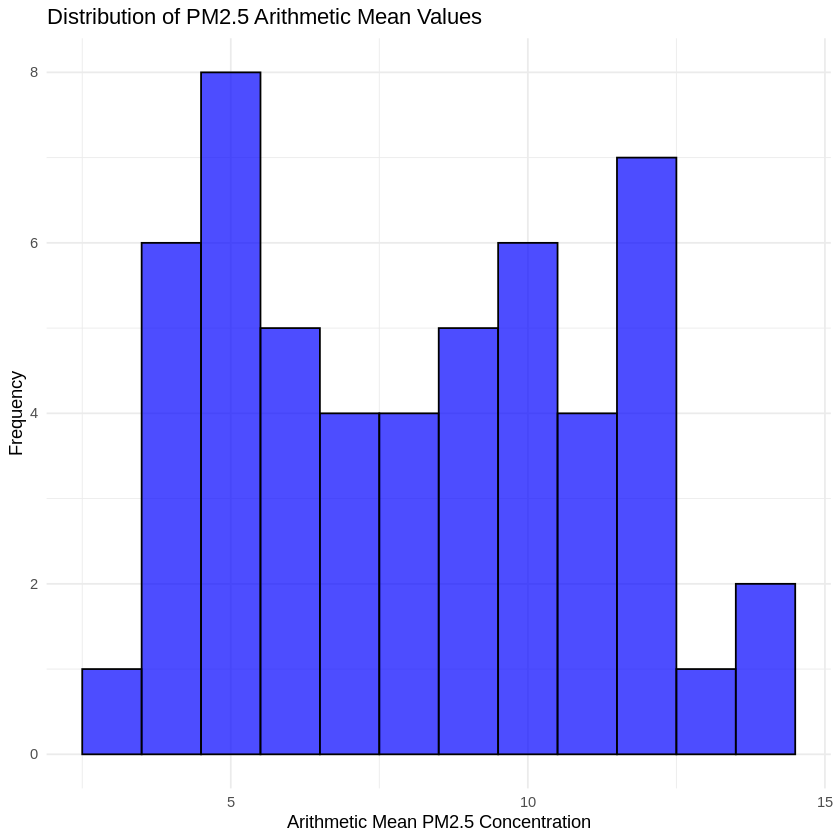

In [38]:
ggplot(data = pm25_filtered, aes(x = arithmetic_mean)) +
  geom_histogram(binwidth = 1, fill = "blue", color = "black", alpha = 0.7) +
  labs(title = "Distribution of PM2.5 Arithmetic Mean Values",
       x = "Arithmetic Mean PM2.5 Concentration",
       y = "Frequency") +
  theme_minimal()

When we compare populations based on their PM 2.5 exposure, we will need a frame of reference for understanding how bad PM 2.5 exposure is.  For this exercise, we will use the following PM 2.5 exposure categories.

1. Low (Good): 0–5 µg/m³
2. Moderate: 5–10 µg/m³
3. High (Unhealthy for Sensitive Groups): 10–15 µg/m³

We'll make a new column in *pm25_filtered* corresponding to the exposure category and add labels to this variable for easy reference.

In [39]:
pm25_filtered <- pm25_filtered %>%
  mutate(pm25_cat = case_when(
    arithmetic_mean <= 5 ~ 1,
    arithmetic_mean > 5 & arithmetic_mean <= 10 ~ 2,
    arithmetic_mean > 10 ~ 3))

In [40]:
pm25_filtered <- pm25_filtered %>%
  mutate(pm25_cat = factor(pm25_cat,
                              levels = c(1, 2, 3),
                              labels = c("low (0-5 µg/m³)",
                                         "moderate (5-10 µg/m³)",
                                         "high (10-15 µg/m³)")))

We're most interested in using the summary data (arithmetic_mean and pm25_cat) in our analysis.  Our data still has a lot of columns we don't plan to use.

In [17]:
colnames(pm25_filtered)

[1] "state_code"                  "county_code"                
 [3] "site_number"                 "parameter_code"             
 [5] "poc"                         "latitude"                   
 [7] "longitude"                   "datum"                      
 [9] "parameter"                   "sample_duration_code"       
[11] "sample_duration"             "pollutant_standard"         
[13] "metric_used"                 "method"                     
[15] "year"                        "units_of_measure"           
[17] "event_type"                  "observation_count"          
[19] "observation_percent"         "validity_indicator"         
[21] "valid_day_count"             "required_day_count"         
[23] "exceptional_data_count"      "null_observation_count"     
[25] "primary_exceedance_count"    "secondary_exceedance_count" 
[27] "certification_indicator"     "arithmetic_mean"            
[29] "standard_deviation"          "first_max_value"            
[31] "first_max_datetime"          "second_max_value"           
[33] "second_max_datetime"         "third_max_value"            
[35] "third_max_datetime"          "fourth_max_value"           
[37] "fourth_max_datetime"         "first_max_nonoverlap_value" 
[39] "first_max_n_o_datetime"      "second_max_nonoverlap_value"
[41] "second_max_n_o_datetime"     "ninety_ninth_percentile"    
[43] "ninety_eighth_percentile"    "ninety_fifth_percentile"    
[45] "ninetieth_percentile"        "seventy_fifth_percentile"   
[47] "fiftieth_percentile"         "tenth_percentile"           
[49] "local_site_name"             "site_address"               
[51] "state"                       "county"                     
[53] "city"                        "cbsa_code"                  
[55] "cbsa"                        "date_of_last_change"

Let's limit the set of columns to the information we will specifically need for our analysis including site number, arithmetic mean PM 2.5, standard deviation PM 2.5, and site geographic coordinates (latitude and longitude).  This will make our data simplier and easier to work with moving forward.

In [41]:
pm25_final <- pm25_filtered %>%
select(site_number, arithmetic_mean, pm25_cat, latitude, longitude)

Next we will convert our monitoring site data to a geographic point dataset which we can map.

## 3. PM 2.5 Monitoring Site Buffer Creation

### 3a. Convert the PM 2.5 Monitoring Data to a Spatial Object

To create buffers around each site we will need to convert the latitude and longitude information in our *pm25_final* to an sf (simple features) object.

In [42]:
# Convert summarized data to an sf object with point geometry
pm25_sf <- st_as_sf(pm25_final, coords = c("longitude", "latitude"), crs = 4326)

Next we will set an appropriate Coordinate Reference System (CRS) that uses meters (EPSG 3310, California Albers).

In [43]:
# Reproject to a projected CRS that uses meters for distance measurements
pm25_sf <- st_transform(pm25_sf, crs = 3310)     # California Albers projection

### 3b. Map the PM 2.5 Monitoring Site Locations in the State of California

Let's also read in a California state boundary shapefile.

In [44]:
california_boundary <- st_read("CA_State.shp")

Reading layer `CA_State' from data source 
  `/home/jovyan/pipelines/6 - Foundational Spatial Analysis/CA_State.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 1 feature and 18 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -13857270 ymin: 3832931 xmax: -12705030 ymax: 5162406
Projected CRS: Popular Visualisation CRS / Mercator


And transform the California boundary to the same CRS as the *pm25_sf* dataset.

In [45]:
california_boundary <- st_transform(california_boundary, crs = st_crs(pm25_sf))

Now let's use ggplot to take a look at the monitoring sites and where they are located in the state of California.  This map will both help us better understand our data and also ensure that our data is property geographically referenced.

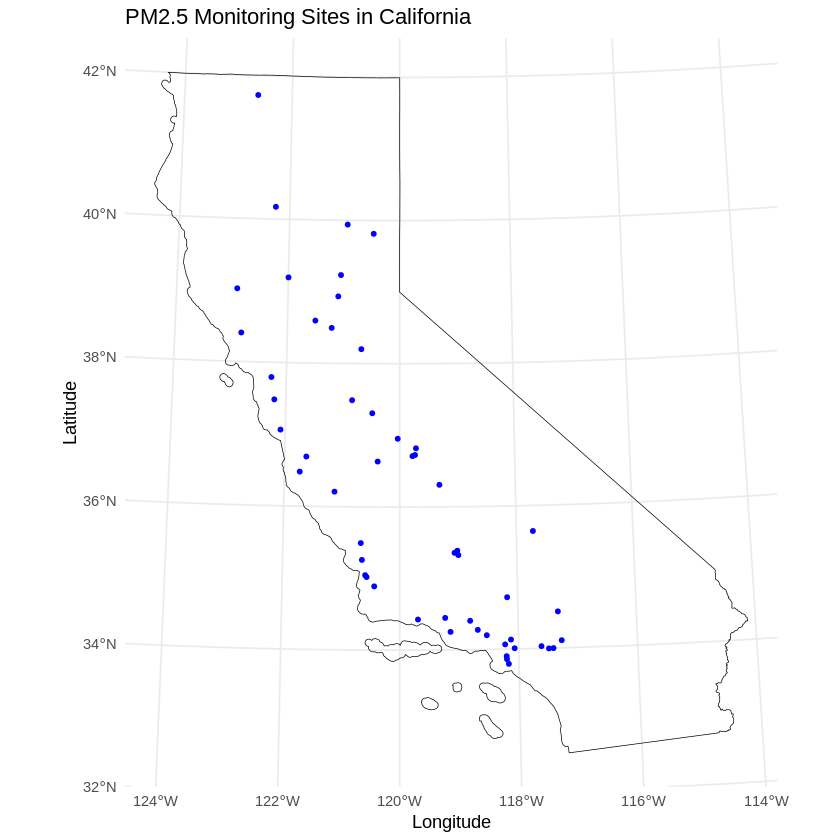

In [46]:
ggplot() +
  geom_sf(data = california_boundary, fill = NA, color = "black") +  # California boundary
  geom_sf(data = pm25_sf, color = "blue", size = 1) +  # PM2.5 monitoring sites
  labs(title = "PM2.5 Monitoring Sites in California", x = "Longitude", y = "Latitude") +
  theme_minimal()

The map looks great!  Next let's create 5 km buffers around each of the monitoring site point locations.

### 3c. Create Buffers Around Each Monitoring Site

Now, create buffer zones around each site (e.g., 5,000 meters or 5 km) to determine the impacted areas.

First we will define the buffer distance as 5000 meters.  We know our data is in meters since we projected the PM 2.5 dataset to the 3310 California Albers CRS, which uses meters for units.

In [47]:
buffer_distance <- 5000

Then we will use the *st_buffer()* function from the *sf* package to create a new geographic feature set *pm25_buffers* corresponding to 5000 meter buffers around each site.

In [48]:
pm25_buffers <- st_buffer(pm25_sf, dist = buffer_distance)

Let's take a look at the new *pm25_buffers* sf dataset.

In [49]:
# cannot run until geojsonio is installed
#head(pm25_sf)

And let's take a look at a map of the buffers.  Since the buffers would be too small to see when looking at the full California map, let's take a look at the buffers within Los Angeles County.

First, we will import a shapefile boundary of Los Angeles County and set it to the same CRS as the pm25_sf and pm25_buffers data.

In [33]:
los_angeles_county_boundary <- st_read("Los_Angeles_County.shp")
los_angeles_county_boundary <- st_transform(los_angeles_county_boundary, crs = st_crs(pm25_buffers))

Reading layer `Los_Angeles_County' from data source 
  `/home/jovyan/pipelines/6 - Foundational Spatial Analysis/Los_Angeles_County.shp' 
  using driver `ESRI Shapefile'
Simple feature collection with 7 features and 17 fields
Geometry type: MULTIPOLYGON
Dimension:     XY
Bounding box:  xmin: -13240860 ymin: 3868152 xmax: -13096340 ymax: 4139895
Projected CRS: WGS 84 / Pseudo-Mercator


Then let's map the locations of the monitoring sites and the corresponding 5000 meter site buffers located in Los Angeles County.  We will color the sites based on the PM 2.5 categories we created earlier.

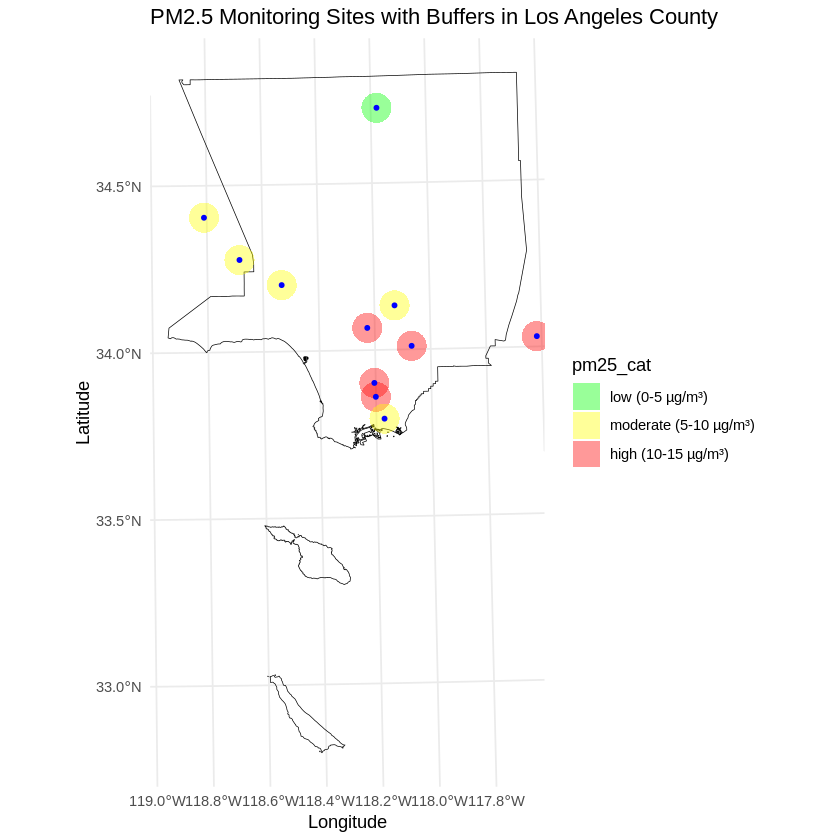

In [104]:
ggplot() +
  geom_sf(data = los_angeles_county_boundary, fill = NA, color = "black", size = 1) +     # Los Angeles County boundary
  geom_sf(data = pm25_buffers, aes(fill = pm25_cat), alpha = 0.4, color = NA) +                # monitoring site buffers
  geom_sf(data = pm25_sf, color = "blue", size = 1) +                                     # monitoring site point locations
  scale_fill_manual(values = c("low (0-5 µg/m³)" = "green",
                               "moderate (5-10 µg/m³)" = "yellow",
                               "high (10-15 µg/m³)" = "red")) +
  labs(title = "PM2.5 Monitoring Sites with Buffers in Los Angeles County",
       x = "Longitude", y = "Latitude") +
  coord_sf(xlim = st_bbox(los_angeles_county_boundary)[c("xmin", "xmax")], 
           ylim = st_bbox(los_angeles_county_boundary)[c("ymin", "ymax")]) +              # focus the map on the geographic extent of LA County
  theme_minimal()

Everything is looking good!  Next we will extract some population data from IPUMS NHGIS using the *ipumsr* package and use that to explore population characteristics by exposure.

## 4. Block Level Population Data Extraction Using ipumsr

Next, we will retrieve census block population data based on the 2020 US Decennial Census from IPUMS NHGIS using the ipumsr package, including geographic boundaries.  For this exercise we will use an NHGIS data extraction with the following specifications:

* Time Series Table: Decennial Census Population Count by Race Harmonized to 2010 Geographies (table CM1)
* Geographic Level: Block Group
* Year: 2020
* Shapefile: 2010 Tiger Line California Block Group Shapefile (060_blck_grp_2010_tl2010)

For a detailed explanation and walkthrough of the IPUMS NHGIS data extraction process using the ipumsr package, refer to the **IPUMS NGHIS Data Extraction** notebook.

In [62]:
extraction <- define_extract_nhgis(description = "I-GUIDE IPUMS 2020 Census Block Group Population by Race",
                                   time_series_tables = tst_spec(name = "CM1",
                                                                 geog_levels = "blck_grp",
                                                                 years = "2020"),
                                   shapefiles = "060_blck_grp_2010_tl2010")

Submit the extraction request and wait for it to complete, then download the resulting data.

In [63]:
# submit extraction  
extraction_submitted <- submit_extract(extraction)

# wait for completion
extraction_complete <- wait_for_extract(extraction_submitted)

# check completion
extraction_complete$status

# get extraction filepath
filepath <- download_extract(extraction_submitted, overwrite = T)

# save the files
dat_nhgis <- read_nhgis(filepath[1])
shp <- read_ipums_sf(filepath[2])

Successfully submitted IPUMS NHGIS extract number 82

Checking extract status...

Waiting 10 seconds...

Checking extract status...

Waiting 20 seconds...

Checking extract status...

IPUMS NHGIS extract 82 is ready to download.



[1] "completed"

  |======================================================================| 100%
  |======================================================================| 100%


Data file saved to /home/jovyan/pipelines/6 - Foundational Spatial Analysis/nhgis0082_csv.zip
Shapefile saved to /home/jovyan/pipelines/6 - Foundational Spatial Analysis/nhgis0082_shape.zip



Now that we have downloaded the population by race data from NHGIS.  The race classifications for these data are as follows:

* CM1AA2020: White
* CM1AB2020: Black or African American
* CM1AC2020: American Indian and Alaska Nativer
* CM1AD2020: Asian
* CM1AE2020: Native Hawaiian and Other Pacific Islander
* CM1AF2020: Some Other Race
* CM1AG2020: Two or More Races

Let's simplify this by creating a % White variable.

In [79]:
dat_nhgis <- dat_nhgis %>%
  mutate(perc_white = CM1AA2020 / (CM1AA2020 + CM1AB2020 + CM1AC2020 + CM1AD2020 + CM1AE2020 + CM1AF2020 + CM1AG2020))

summary(dat_nhgis$perc_white)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max.    NA's 
 0.0000  0.4227  0.7073  0.6270  0.8630  1.0000     767 

Census blocks in the United States range from 0% to 100% White with an average of 70.7% White and a median of 62.7% White.

Let's create a simplified version of our population data which only includes the subset of variables we are interested in for our analysis.

In [81]:
head(dat_nhgis)

GISJOIN,GEOGYEAR,STATE,STATEA,COUNTY,COUNTYA,TRACTA,BLCK_GRPA,CM1AA2020,CM1AA2020L,⋯,CM1AE2020,CM1AE2020L,CM1AE2020U,CM1AF2020,CM1AF2020L,CM1AF2020U,CM1AG2020,CM1AG2020L,CM1AG2020U,perc_white
<chr>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
G01000100201001,2010,Alabama,01,Autauga County,001,020100,1,433,396,⋯,0,0,0,12,9,12,52,43,52,0.7530435
G01000100201002,2010,Alabama,01,Autauga County,001,020100,2,956,956,⋯,3,3,3,23,23,23,70,70,70,0.7966667
G01000100202001,2010,Alabama,01,Autauga County,001,020200,1,311,311,⋯,0,0,0,7,7,7,32,32,32,0.3193018
G01000100202002,2010,Alabama,01,Autauga County,001,020200,2,531,531,⋯,4,4,4,13,13,16,39,39,48,0.4912118
G01000100203001,2010,Alabama,01,Autauga County,001,020300,1,1672,1672,⋯,3,3,3,44,44,44,134,134,134,0.7034077
G01000100203002,2010,Alabama,01,Autauga County,001,020300,2,572,572,⋯,3,3,3,5,5,5,43,43,43,0.6817640


In [83]:
dat_nhgis <- dat_nhgis %>% select("GISJOIN", "BLCK_GRPA", "perc_white")

head(dat_nhgis)

GISJOIN,BLCK_GRPA,perc_white
<chr>,<dbl>,<dbl>
G01000100201001,1,0.7530435
G01000100201002,2,0.7966667
G01000100202001,1,0.3193018
G01000100202002,2,0.4912118
G01000100203001,1,0.7034077
G01000100203002,2,0.6817640


Next will merge the population data with the corresponding downloaded shapefile, convert the new file to an sf object, and set it to have the same CRS as our PM 2.5 data.

In [84]:
# merge the population and spatial data from the NHGIS API call
nhgis_shp <- merge(dat_nhgis, shp, by = "GISJOIN")

# transform the resulting file to an sf object
nhgis_shp <- st_as_sf(nhgis_shp)

# reproject the sf object to the same CRS as the PM 2.5 data
nhgis_shp <- st_transform(nhgis_shp, crs = st_crs(pm25_buffers))

And we'll take a look at the California block group map showing percent White population by block group.

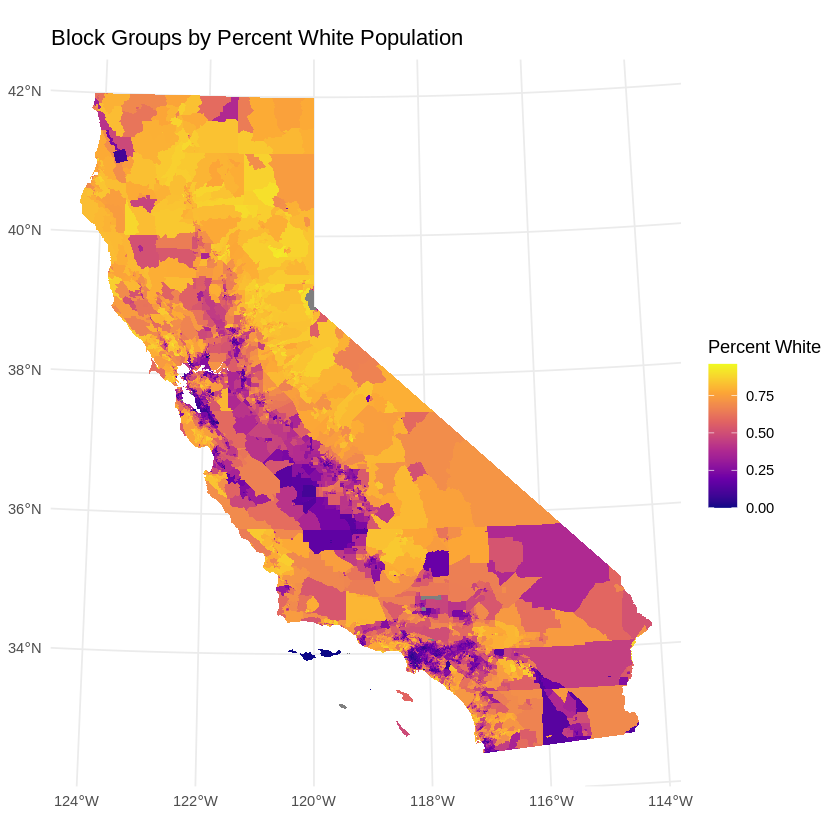

In [87]:
ggplot(data = nhgis_shp) +
  geom_sf(aes(fill = perc_white), color = NA) +                      # color block groups by perc_white
  scale_fill_viridis_c(option = "plasma", na.value = "grey50") +     # use the "plasma" color scale and handle NA values
  labs(title = "Block Groups by Percent White Population",
       fill = "Percent White") +
  theme_minimal()

## 5. Exposed Population Count Buffer Analysis

Step 5: Perform Spatial Join to Count Population Within Buffers

Finally, use a spatial join to intersect the population data with the buffers.  This will count the number of people within each buffer zone.

In [89]:
# Spatial join - associate each block group with the PM2.5 buffer it intersects
# This will create duplicates for block groups that intersect multiple buffers
bg_pm25_joined <- st_join(nhgis_shp, pm25_sf, join = st_intersects)

In [96]:
# Summarize percent white for each PM2.5 category
# Group by the PM2.5 category and calculate the mean percentage white population
summary_percent_white <- bg_pm25_joined %>%
  group_by(pm25_cat) %>%
  summarize(mean_perc_white = mean(perc_white, na.rm = TRUE),
            median_perc_white = median(perc_white, na.rm = TRUE),
            .groups = 'drop') %>%
  filter(!is.na(pm25_cat))

In [97]:
# View the summary
as.data.frame(summary_percent_white)

pm25_cat,mean_perc_white,median_perc_white,geometry
<fct>,<dbl>,<dbl>,<MULTIPOLYGON [m]>
low (0-5 µg/m³),0.6433147,0.7414753,MULTIPOLYGON (((-59573.81 -...
moderate (5-10 µg/m³),0.4998886,0.4788457,MULTIPOLYGON (((-144612.2 -...
high (10-15 µg/m³),0.3301190,0.2680723,MULTIPOLYGON (((91658.96 -2...


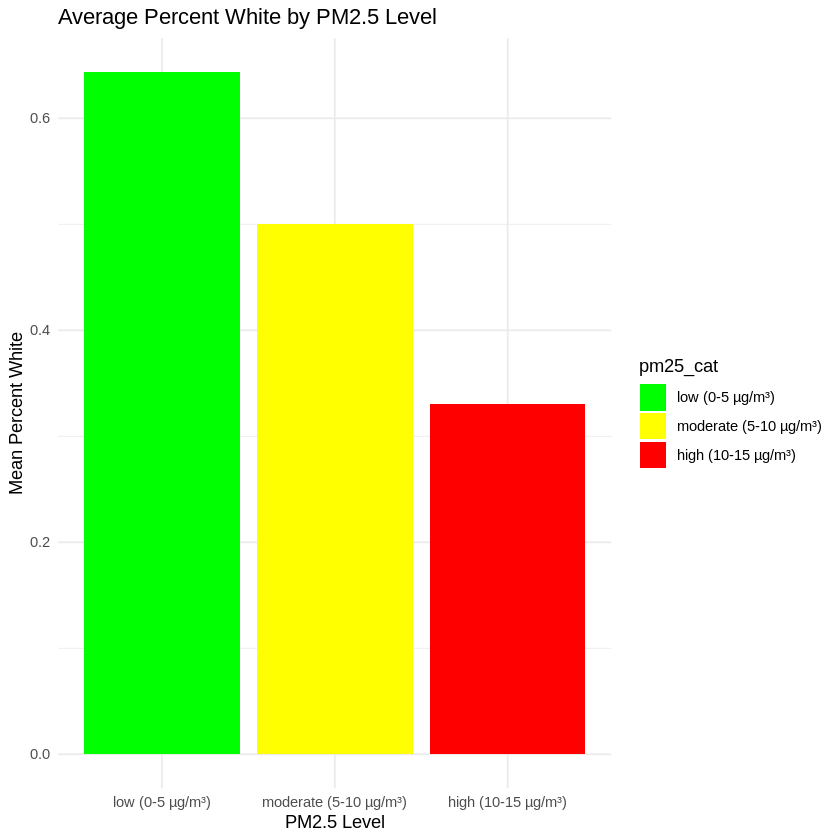

In [103]:
ggplot(data = summary_percent_white,
       aes(x = pm25_cat, y = mean_perc_white, fill = pm25_cat)) +
  geom_bar(stat = "identity") +
  labs(title = "Average Percent White by PM2.5 Level",
       x = "PM2.5 Level",
       y = "Mean Percent White") +
  scale_fill_manual(values = c("low (0-5 µg/m³)" = "green",
                               "moderate (5-10 µg/m³)" = "yellow",
                               "high (10-15 µg/m³)" = "red")) +
  theme_minimal()

Our analysis shows there is a relationship between race and PM 2.5 exposure level for the subset of California block groups which are within 5000 meters of an EPA AQS PM 2.5 monitoring site.  Populations close to monitoring sites showing low PM 2.5 (0-5 µg/m³) are, on averge, 64% White while populations close to monitoring sites showing high PM 2.5 (10-15 µg/m³) are, on average, only 33% White.

This initial exploratory analysis indicates there may be an environmental justice issue where areas with larger populations of color are more exposed to PM 2.5.

## Conclusion

In [105]:
saveRDS(pm25_sf, file = "pm25_sf.rds")

## Next Steps

From here, we recommend exploring the following notebooks:

* ...